# Part III: Build Transformer with PyTorch

## Step 1: Data Exploration and Preprocessing

(a) Dataset: AG News Classification Dataset

- The URL is given in the 'References' in the end of the file.
- CSV file name: ag_news_csv.tar.gz
- Description: This dataset contains 120k training samples and 7.6k testing samples aabout four classes. It has 30k training and 1.9k testing per class. It is based on over 1 million news articles collected by ComeToMyHead from more than 2k ones over a year.
- the task is a text classification problem using this dataset to classify news articles into one of four categories depending on title and description.
- Categories: 1(World), 2(Sports), 3(Business), 4(Sci/Tech)

(b) Data exploration -> The main statistics about the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import math
from gensim.models import Word2Vec
from torchinfo import summary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')



df = pd.read_csv('ag_news_csv/train.csv', header=None, names=['category', 'title', 'description'])
print(df.head())
print("---------------------------------------------------------")
print("Count information about this dataset")
df.info()
print("---------------------------------------------------------")
print("Statistics about this dataset")
print(df.describe())


print("The number of missing values")
print(df.isnull().sum())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seokwoopark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seokwoopark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/seokwoopark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


   category                                              title  \
0         3  Wall St. Bears Claw Back Into the Black (Reuters)   
1         3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2         3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3         3  Iraq Halts Oil Exports from Main Southern Pipe...   
4         3  Oil prices soar to all-time record, posing new...   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
---------------------------------------------------------
Count information about this dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------

(c) Text preprocessing

   - This code compute the count of each category in the dataset and mapping the numeric labels from 1 to 4 into corresponding the column's labels.
   - The description and title are tokenized by NLTK’s word_tokenize. This process can remove tokens that are not alphabet or that are in the English stopwords list.
   - The next one defines a vocabulary by iterating through the title and description texts. It collects all unique tokens and sort them in order to create a consistent from word to index mapping.
   - All cleaned sentences are combined into a list and used to train a Word2Vec model with a 100 dimensional space. This lead to generateing vector representations for each word.
   - Finally, I can have an embedding matrix when each row corresponds to a word from the vocabulary

In [2]:
category_counts = df['category'].value_counts()
category_mapping = {
    1: "1 - World",
    2: "2 - Sports",
    3: "3 - Business",
    4: "4 - Sci/Tech"
}

print(category_counts)

labels = [category_mapping.get(cls, str(cls)) for cls in category_counts.index]
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    text_cleaned = " ".join(tokens)

    return text_cleaned


df['title'] = df['title'].astype(str).apply(preprocess_text)
df['description'] = df['description'].astype(str).apply(preprocess_text)

df['title_length'] = df['title'].apply(lambda x: len(x.split()))
df['description_length'] = df['description'].apply(lambda x: len(x.split()))

vocab = set()

for sentence in df['title']:
    vocab.update(sentence.split())
    
for sentence in df['description']:
    vocab.update(sentence.split())

vocab = sorted(vocab)
word_to_index = {word: idx for idx, word in enumerate(vocab)}
sentences = df['title'].str.split().tolist() + df['description'].str.split().tolist()
word_to_vector_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
embedding_dimension = 100
embeddings_matrix = np.zeros((len(vocab), embedding_dimension))

for word, idx in word_to_index.items():
    if word in word_to_vector_model.wv:
        embeddings_matrix[idx] = word_to_vector_model.wv[word]

category
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


(d) Visualization

- The bar chart compares the mean number of words in descriptions acbout four categories. Category 1 has the highest average. Category 2 shows a slightly lower mean.
- The orange histogram indicates how many words appear in the titles on average. Most titles have between 4 and 7 words
- The green histogram reporesents how many words descriptions contain. The length of descriptions is usually from 15 to 25 words. The highest frequency is about 27k.


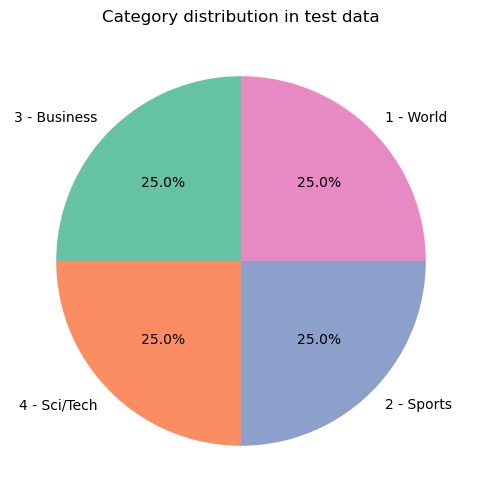

/var/folders/f1/vxclkb5x3hg7_3074_kz1cjm0000gn/T/ipykernel_12400/2539617354.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'category', y = 'description_length', data = df, estimator = np.mean, palette = 'Set3')


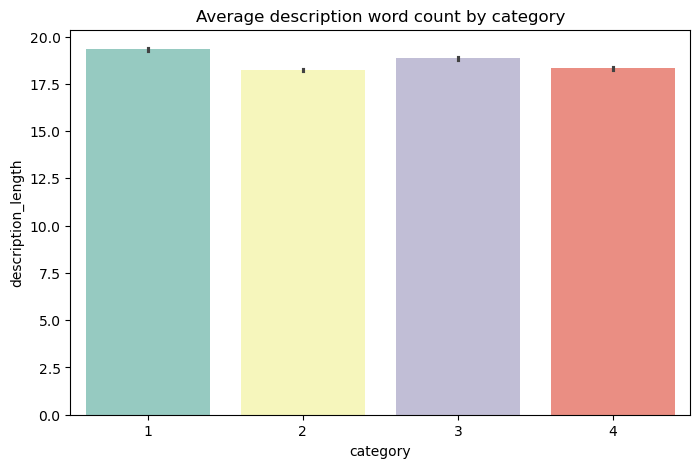

---------------------------------------------------------


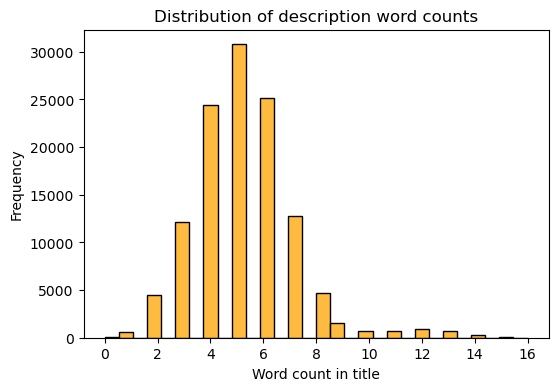

---------------------------------------------------------


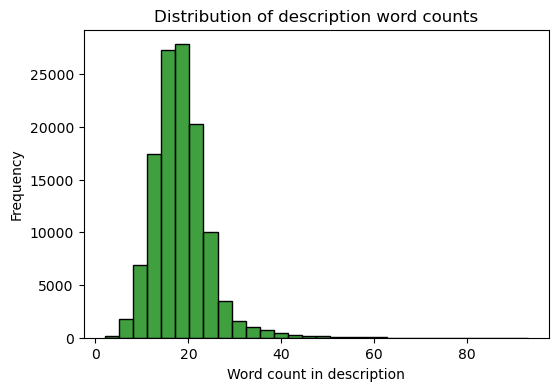

In [3]:
colors = sns.color_palette("Set2", n_colors = len(category_counts))

plt.figure(figsize = (6,6))
plt.pie(category_counts, labels = labels, colors = colors, autopct = '%1.1f%%', startangle = 90)
plt.title("Category distribution in test data")
plt.show()

plt.figure(figsize = (8,5))
sns.barplot(x = 'category', y = 'description_length', data = df, estimator = np.mean, palette = 'Set3')
plt.title('Average description word count by category')
plt.show()


print("---------------------------------------------------------")

plt.figure(figsize = (6,4))
sns.histplot(df['title_length'], bins = 30, color = 'orange')
plt.title("Distribution of description word counts")
plt.xlabel("Word count in title")
plt.ylabel("Frequency")
plt.show()

print("---------------------------------------------------------")

plt.figure(figsize = (6,4))
sns.histplot(df['description_length'], bins = 30, color = 'green')
plt.title("Distribution of description word counts")
plt.xlabel("Word count in description")
plt.ylabel("Frequency")
plt.show()


## Step 2: Model Construction

(a) Model architecture

- PositionalEncoding: This creates a fixed positional encoding tensor based on the model dimension and maximum sequence length. Even indexs are assigned to sin computation and odd indexs are assigned to cos computation. It has a no trainable buffer
- TransformerClassifier: I implements a text classification model using a Transformer encoder. It begins with an embedding layer to map input tokens to vectors. The resulting embeddings have positional information using the PositionalEncoding class. The embeddings pass through a multi layer Transformer encoder. The output can be defined by the mean about the sequence dimension. A fully connected layer converts the representation into logits corresponding to four classes.
- Why decoder is not used: In classification tasks, the primary goal is to understand and represent the input text than generating new text. Only the encoder is required to capture the context relationships within the input. The decoder is generally used for generative tasks like translation or text generation.

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_length = 5000, dropout = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        positional_encoding = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype = torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(100) / d_model))
        positional_encoding[:, 0::2] = torch.sin(position * division_term)
        positional_encoding[:, 1::2] = torch.cos(position * division_term)

        self.register_buffer("positional_encoding", positional_encoding.unsqueeze(1))
    
    def forward(self, x):
        sequence_len = x.size(0)
        x = x + self.positional_encoding[:sequence_len, :]
        
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension = 100, nhead = 4, hidden_dim = 256, num_layers = 2, num_classes = 4, dropout = 0.1, embeddings_matrix = None):
        super().__init__()
        
        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension, padding_idx = 0)

        if embeddings_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embeddings_matrix))

        self.position_encoder = PositionalEncoding(d_model = embedding_dimension, dropout = dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model= embedding_dimension, nhead = nhead, dim_feedforward = hidden_dim, dropout = dropout, batch_first = False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_layers)
        self.fc = nn.Linear(embedding_dimension, num_classes)
    
    def forward(self, source):
        source = source.transpose(0, 1)
        embedded = self.embedding(source)
        embedded = self.position_encoder(embedded)
        encoded = self.transformer_encoder(embedded)
        output = encoded.mean(dim = 0)
        logits = self.fc(output)
        
        return logits

(b)	Model summary using torchinfo.summary

In [5]:
vocabulary_size = len(word_to_index)
num_classes = 4
embedding_dimension = 100
max_length = 30

model = TransformerClassifier(
    vocabulary_size = vocabulary_size,
    embedding_dimension = embedding_dimension,
    nhead = 4,
    hidden_dim = 512,
    num_layers = 3,
    num_classes = num_classes,
    dropout = 0.3,
    embeddings_matrix = embeddings_matrix
)

dummy_input = torch.randint(0, vocabulary_size, (32, max_length), dtype = torch.long)
summary(model,input_data = dummy_input,dtypes = [torch.long])

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [32, 4]                   --
├─Embedding: 1-1                              [30, 32, 100]             5,984,400
├─PositionalEncoding: 1-2                     [30, 32, 100]             --
│    └─Dropout: 2-1                           [30, 32, 100]             --
├─TransformerEncoder: 1-3                     [30, 32, 100]             --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [30, 32, 100]             143,812
│    │    └─TransformerEncoderLayer: 3-2      [30, 32, 100]             143,812
│    │    └─TransformerEncoderLayer: 3-3      [30, 32, 100]             143,812
├─Linear: 1-4                                 [32, 4]                   404
Total params: 6,416,240
Trainable params: 6,416,240
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 188.85
Input size (MB): 0.01
Forward

## Step 3: Training the Transformer

(a) Spliting the dataset

- This splits the dataset into training with 80%, validation with 10%, and test with 10%
- text_to_id_sequence: It is used in order to mapp each token to the corresponding index from the dictionary
- convert_dataset_to_token_property: This function extracts the title and category labels from the dataset and converts each title into a token id sequence using text_to_id_sequence.

In [6]:
train_set, temporary = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
validation_set, test_set = train_test_split(temporary, test_size = 0.50, random_state = 42, stratify = temporary['category'])


def text_to_id_sequence(text, word_to_index, max_length = 30):
    tokens = text.split()
    token_id_sequence = [word_to_index.get(token, 0) for token in tokens]
    token_id_sequence = token_id_sequence[:max_length]
    token_id_sequence += [0] * (max_length - len(token_id_sequence))

    return token_id_sequence

def convert_dataset_to_token_property(dataset):
    texts = dataset['title'].tolist()
    labels = (dataset['category'] - 1).tolist()
    id_sequence = [text_to_id_sequence(text, word_to_index, max_length) for text in texts]

    return id_sequence, labels

train_id_sequence, train_labels = convert_dataset_to_token_property(train_set)
val_id_sequence, val_labels = convert_dataset_to_token_property(validation_set)
test_id_sequence, test_labels = convert_dataset_to_token_property(test_set)

train_id_sequence_tensor = torch.tensor(train_id_sequence, dtype = torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype = torch.long)
validation_id_sequence_tensor = torch.tensor(val_id_sequence, dtype = torch.long)
validation_labels_tensor = torch.tensor(val_labels, dtype = torch.long)
test_id_sequence_tensor = torch.tensor(test_id_sequence, dtype = torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype = torch.long)

train_dataset = TensorDataset(train_id_sequence_tensor, train_labels_tensor)
val_dataset = TensorDataset(validation_id_sequence_tensor, validation_labels_tensor)
test_dataset = TensorDataset(test_id_sequence_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

(b) Training loop

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
epochs = 10
patience = 4
best_validation_accuracy = 0.0
early_stopping_count = 0

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
validation_roc_aucs = []


for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss = total_train_loss + loss.item() * inputs.size(0)
        predictions = outputs.argmax(dim = 1)
        total_train_correct = total_train_correct + (predictions == labels).sum().item()
        total_train_samples = total_train_samples + labels.size(0)
    
    average_train_loss = total_train_loss / total_train_samples
    train_accuracy = total_train_correct / total_train_samples
    training_losses.append(average_train_loss)
    training_accuracies.append(train_accuracy)

    model.eval()
    total_validation_loss = 0.0
    total_validation_correct = 0
    total_validation_samples = 0

    all_validation_probability = []
    all_validation_targets = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_validation_loss = total_validation_loss + loss.item() * inputs.size(0)
            predictions = outputs.argmax(dim = 1)
            total_validation_correct = total_validation_correct + (predictions == labels).sum().item()
            total_validation_samples = total_validation_samples + labels.size(0)
            probs = torch.softmax(outputs, dim = 1)
            all_validation_probability.append(probs.cpu().numpy())
            all_validation_targets.append(labels.cpu().numpy())

    average_validation_loss = total_validation_loss / total_validation_samples
    validation_accuracy = total_validation_correct / total_validation_samples
    validation_losses.append(average_validation_loss)
    validation_accuracies.append(validation_accuracy)

    all_validation_probability = np.concatenate(all_validation_probability, axis = 0)
    all_validation_targets = np.concatenate(all_validation_targets, axis = 0)
    all_validation_targets_onehot = label_binarize(all_validation_targets, classes = list(range(num_classes)))
    roc_auc = roc_auc_score(all_validation_targets_onehot, all_validation_probability, multi_class = 'ovr', average = 'macro')
    validation_roc_aucs.append(roc_auc)
    
    print(f"Epoch {epoch + 1} of {epochs} -> Train Loss: {average_train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, " +
          f"Validation Loss: {average_validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.3f}, Validation ROC AUC: {roc_auc:.3f}")
    
    
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        early_stopping_count = 0
    else:
        early_stopping_count = early_stopping_count + 1
    
    if early_stopping_count >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break


total_test_loss = 0.0
total_test_correct = 0
total_test_samples = 0

all_test_probability = []
all_test_targets = []
all_test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        total_test_loss += loss.item() * inputs.size(0)
        predictions = outputs.argmax(dim = 1)
        total_test_correct += (predictions == labels).sum().item()
        total_test_samples += labels.size(0)
        probs = torch.softmax(outputs, dim = 1)
        all_test_probability.append(probs.cpu().numpy())
        all_test_targets.append(labels.cpu().numpy())
        all_test_predictions.append(predictions.cpu().numpy())

test_loss = total_test_loss / total_test_samples
test_accuracy = total_test_correct / total_test_samples
all_test_probability = np.concatenate(all_test_probability, axis = 0)
all_test_targets = np.concatenate(all_test_targets, axis = 0)
all_test_predictions = np.concatenate(all_test_predictions, axis = 0)
all_test_targets_onehot = label_binarize(all_test_targets, classes = list(range(num_classes)))
test_roc_auc = roc_auc_score(all_test_targets_onehot, all_test_probability, multi_class = 'ovr', average = 'macro')
precision, recall, f1, _ = precision_recall_fscore_support(all_test_targets, all_test_predictions, average = 'macro')

print('------------------------------------------------------------------------------------------------')
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}, Test ROC AUC: {test_roc_auc:.3f}")
print(f"Test Precision: {precision:.3f}, Test Recall: {recall:.3f}, Test F1 Score: {f1:.3f}")

Epoch 1 of 10 -> Train Loss: 0.567, Train Accuracy: 0.794, Validation Loss: 0.435, Validation Accuracy: 0.851, Validation ROC AUC: 0.966
Epoch 2 of 10 -> Train Loss: 0.437, Train Accuracy: 0.846, Validation Loss: 0.417, Validation Accuracy: 0.859, Validation ROC AUC: 0.970
Epoch 3 of 10 -> Train Loss: 0.374, Train Accuracy: 0.870, Validation Loss: 0.381, Validation Accuracy: 0.871, Validation ROC AUC: 0.973
Epoch 4 of 10 -> Train Loss: 0.331, Train Accuracy: 0.885, Validation Loss: 0.408, Validation Accuracy: 0.876, Validation ROC AUC: 0.971
Epoch 5 of 10 -> Train Loss: 0.298, Train Accuracy: 0.897, Validation Loss: 0.413, Validation Accuracy: 0.874, Validation ROC AUC: 0.972
Epoch 6 of 10 -> Train Loss: 0.276, Train Accuracy: 0.904, Validation Loss: 0.424, Validation Accuracy: 0.875, Validation ROC AUC: 0.972
Epoch 7 of 10 -> Train Loss: 0.261, Train Accuracy: 0.909, Validation Loss: 0.441, Validation Accuracy: 0.875, Validation ROC AUC: 0.971
Epoch 8 of 10 -> Train Loss: 0.244, Train

## Step 4: Evaluation and Optimization

(a) The optimization techniques for the performance of the model.

- Adam: Adaptive Moment Estimation Optimizer manages the learning rate for each parameter based on the first and second moments of the gradients. This leads to faster and more stable convergence.
- Dropout: This randomly deactivates a some part of neurons during each training iteration. This can prevent neurons from relying too much on specific neurons.
- Early Stopping: The early stopping monitors validation accuracy and stops training if there is no improvement for a specified number

(b) Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [8]:
torch.save(model.state_dict(), 'best_model_part3.pth')

(c) Graph for the training and validation accuracy over epochs.

Both the training and validation accuracy increase during the first few epochs. Around the middle epochs, validation accuracy begins to fluctuacte. The training accuracy continues to increase by 90% range. This indicates that the model is fitting the training data more tightly over epochs. The validation performance shows a smaller accuracy than the training one.

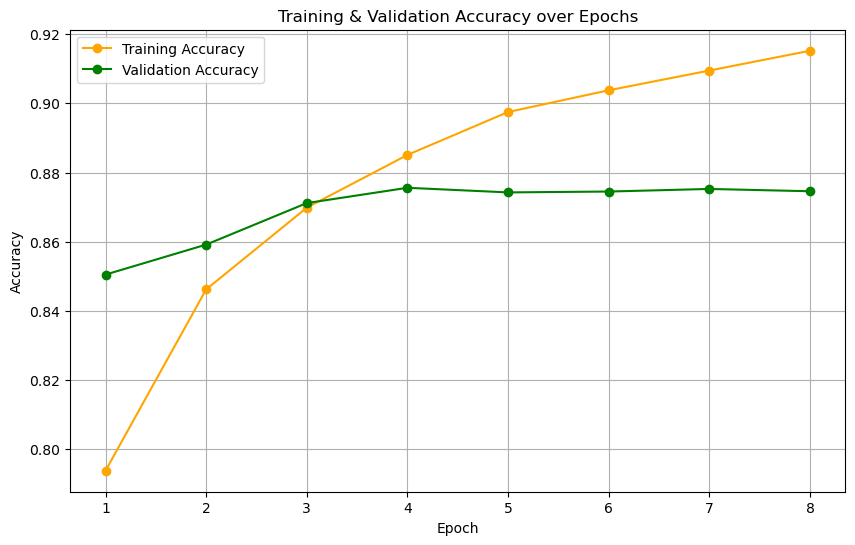

In [9]:
epochs_range = range(1, len(training_accuracies) + 1)

plt.figure(figsize = (10, 6))
plt.plot(epochs_range, training_accuracies, label = 'Training Accuracy', marker = 'o', color = 'orange')
plt.plot(epochs_range, validation_accuracies, label = 'Validation Accuracy', marker = 'o', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy over Epochs')
plt.xticks(range(1, len(training_accuracies) + 1, 1))
plt.legend()
plt.grid(True)
plt.show()


(d) Graph for the training and validation loss over epochs.

In the early epochs, both training and validation loss decrease. But the training loss continues to steadily drop during the middle of epochs. The validation loss fluctuates and slightly increases. The generalization on the validation begins to degrade in some part of epochs.


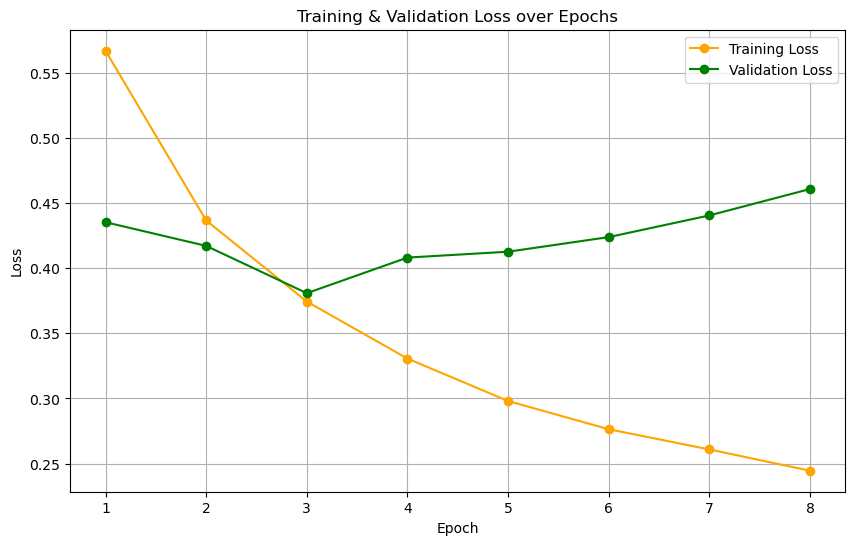

In [10]:
epochs_range = range(1, len(training_losses) + 1)

plt.figure(figsize = (10, 6))
plt.plot(epochs_range, training_losses, label = 'Training Loss', marker = 'o', color = 'orange')
plt.plot(epochs_range, validation_losses, label = 'Validation Loss', marker = 'o', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.xticks(range(1, len(training_losses) + 1, 1))
plt.legend()
plt.grid(True)
plt.show()


(e) Graph for the training and validation loss over epochs.

The Validation ROC AUC starts relatively high. It reachs out peak around 0.97 range. And it gets back near 0.97 again. This plot represents the model maintains good overall discriminative ability.

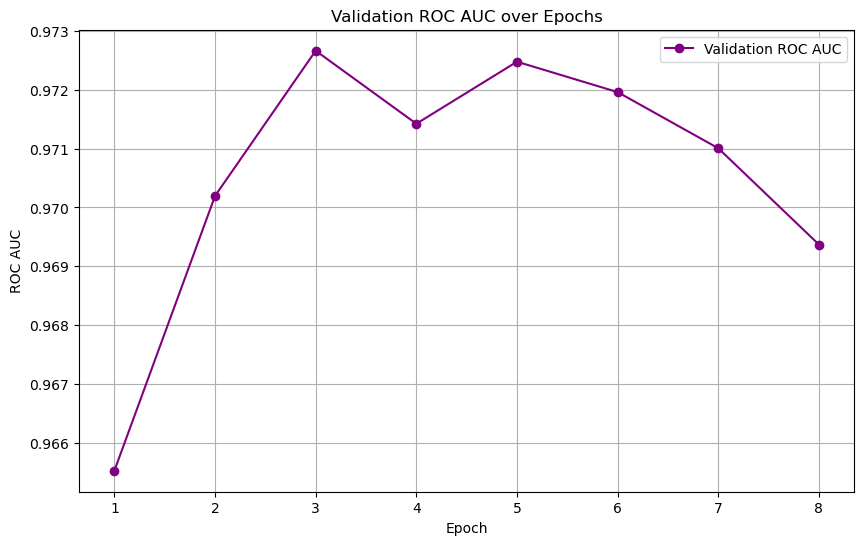

In [ ]:
epochs_range = range(1, len(validation_roc_aucs) + 1)

plt.figure(figsize = (10, 6))
plt.plot(epochs_range, validation_roc_aucs, marker = 'o', color = 'purple', label = 'Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Validation ROC AUC over Epochs')
plt.xticks(range(1, len(validation_roc_aucs) + 1))
plt.legend()
plt.grid(True)
plt.show()


## References

- Dataset (https://drive.google.com/drive/u/0/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ)
- Attention Is All You Need (https://arxiv.org/abs/1706.03762)
- PyTorch Transformer (https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)
- Gensim Word2Vec API (https://radimrehurek.com/gensim/models/word2vec.html)
- Illustrated Transformer (https://jalammar.github.io/illustrated-transformer/)
- Distributed Representations of Sentences and Documents (https://arxiv.org/abs/1405.4053)


## Contribution Summary

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Apoorv sood(apoorvso)  | Step 1 | 50   |
| Seokwoo Park(seokwoop)  | Step 1 |  50 |
| Apoorv sood(apoorvso)  | Step 2 |  50 |
| Seokwoo Park(seokwoop)  | Step 2 |  50 |
| Apoorv sood(apoorvso)  | Step 3 |  50 |
| Seokwoo Park(seokwoop)  | Step 3 |   50 |
| Apoorv sood(apoorvso)  | Step 4 |  50 |
| Seokwoo Park(seokwoop)  | Step 4 |   50 |
|   | **Total** |  100 for each step |